In [1]:
import cv2
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import random
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [3]:
class dataset(Dataset):
    def __init__(self, root):
        self.image_path=root+"Images/"
        self.labels_path=root+"Labels/"
        self.img_name = [img for img in sorted(os.listdir(self.image_path))]
        self.label_name = [label for label in sorted(os.listdir(self.labels_path))]
         
    def __getitem__(self, index):
        path = os.path.join(self.image_path, str(self.img_name[index]))
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img = img / 255
        img = torch.as_tensor(img).permute(2, 0, 1)
        
        label_name = self.img_name[index][:-4] + "txt"
        lpath = os.path.join(self.labels_path, str(label_name))
        with open(lpath, 'r') as l:
            l_length = int(l.readline())
            boxes = []
            for i in range(l_length):
                boxes.append(list(map(int, l.readline().split())))
                
        target = {}
        target["boxes"] = torch.Tensor(boxes).type(torch.int64)
        areas = []
        for i in range(len(boxes)):
            tmp = (boxes[i][2] - boxes[i][0]) * (boxes[i][3] - boxes[i][1])
            areas.append(tmp)
            
        target["area"] = torch.Tensor(areas)
        labels = []
        for i in range(len(boxes)):
            labels.append(1)
        target["labels"] = torch.Tensor(labels).type(torch.int64)
        target["image_id"] = torch.Tensor([index])
        
        img = img.to(device)
        for key in target:
            if isinstance(target[key], torch.Tensor):
                target[key] = target[key].to(device)
        
        return img, target

    def __len__(self):
        return len(self.img_name)
        

In [4]:
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
backbone.out_channels = 1280
anchor_generator = AnchorGenerator(
    sizes=((8, 16, 32, 64),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=10,
    sampling_ratio=2
)
model = FasterRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

In [5]:
def collate_fn(batch):
    return tuple(zip(*batch))
dataset = dataset("./")
train_loader = DataLoader(dataset, batch_size=3, shuffle=True, num_workers=0, collate_fn=collate_fn)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [6]:
for i in range(3):
    train_loss = 0
    model.train()
    for img, target in train_loader:
        loss_dic = model(img, target)
        loss = sum(loss for loss in loss_dic.values())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss
    print("Epoch: {} | Train Loss: {}".format(i+1, train_loss))

Epoch: 1 | Train Loss: 161.54039001464844
Epoch: 2 | Train Loss: 129.41058349609375
Epoch: 3 | Train Loss: 116.3206787109375


In [28]:
def testGun():
    num = random.randint(1, 334)
    img_test, target_test = dataset[num]
    model.eval()
    pred = model([img_test])
    pred[0].keys()
    img_plot = (np.clip(img_test.numpy().transpose((1, 2, 0)), 0, 1) * 255).astype(np.uint8)
    for i in range(len(target_test["boxes"])):
        cv2.rectangle(img_plot, (target_test["boxes"][i][0].item(), target_test["boxes"][i][1].item()), (target_test["boxes"][i][2].item(), target_test["boxes"][i][3].item()), (0, 255, 0), 1)
    plt.imshow(img_plot)
    img_test = img_test.numpy().transpose(1, 2, 0)
    for i in range(4):
        if i >= len(pred[0]["boxes"]):
            break
        label = pred[0]["labels"][i].item()
        p = pred[0]["scores"][i].item()
        bound = pred[0]["boxes"][i].tolist()
        t, l, r, b = [round(x) for x in bound]
        color = ((255 - 18*i) % 255, (125 - 18*i) % 255, 28*i%255)
        if p > 0.3:
            cv2.rectangle(img_test, (t, l), (r, b), color, 1)
            cv2.putText(img_test, "Gun: " + str(round(p, 2)), (t - 5, l), cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.3, color= color, thickness=1)
            plt.figure(figsize=(20, 20))
    plt.imshow(img_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


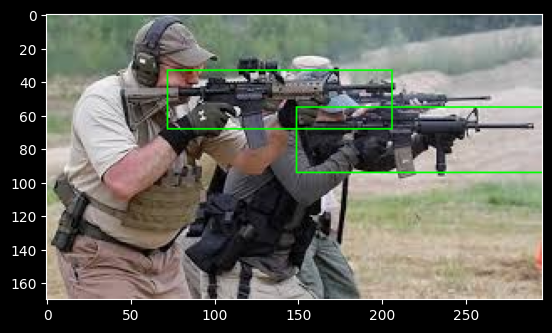

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

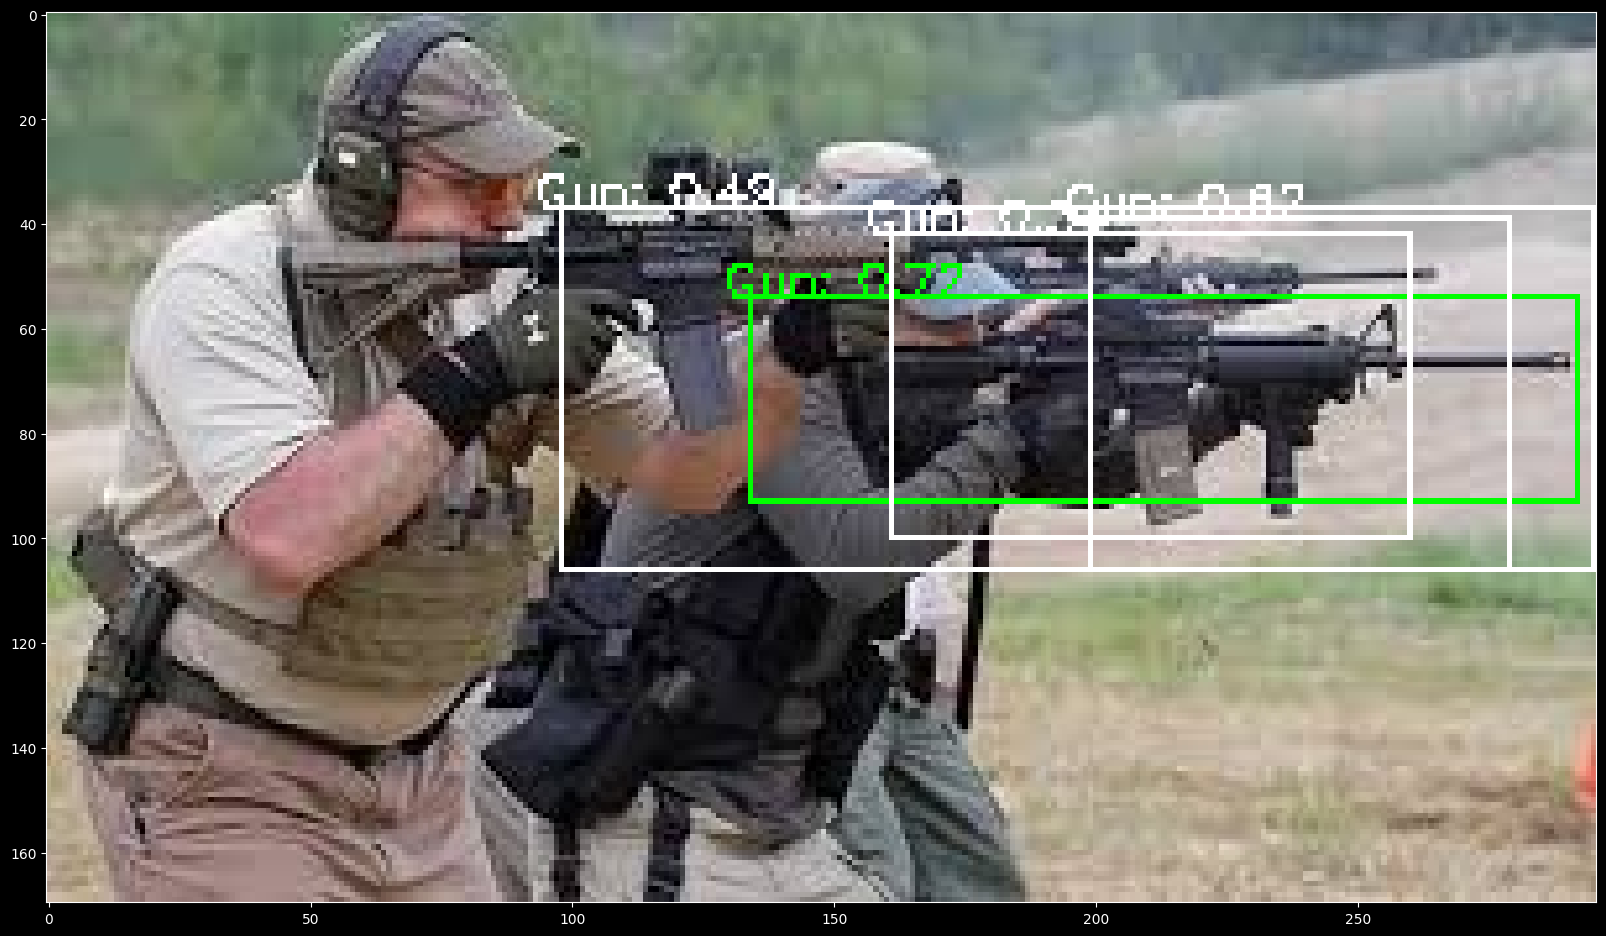

In [29]:
testGun()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


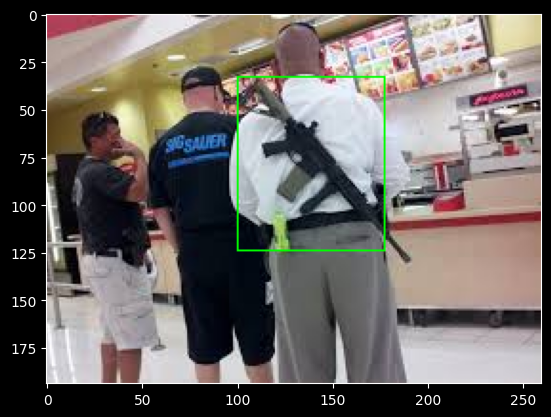

<Figure size 2000x2000 with 0 Axes>

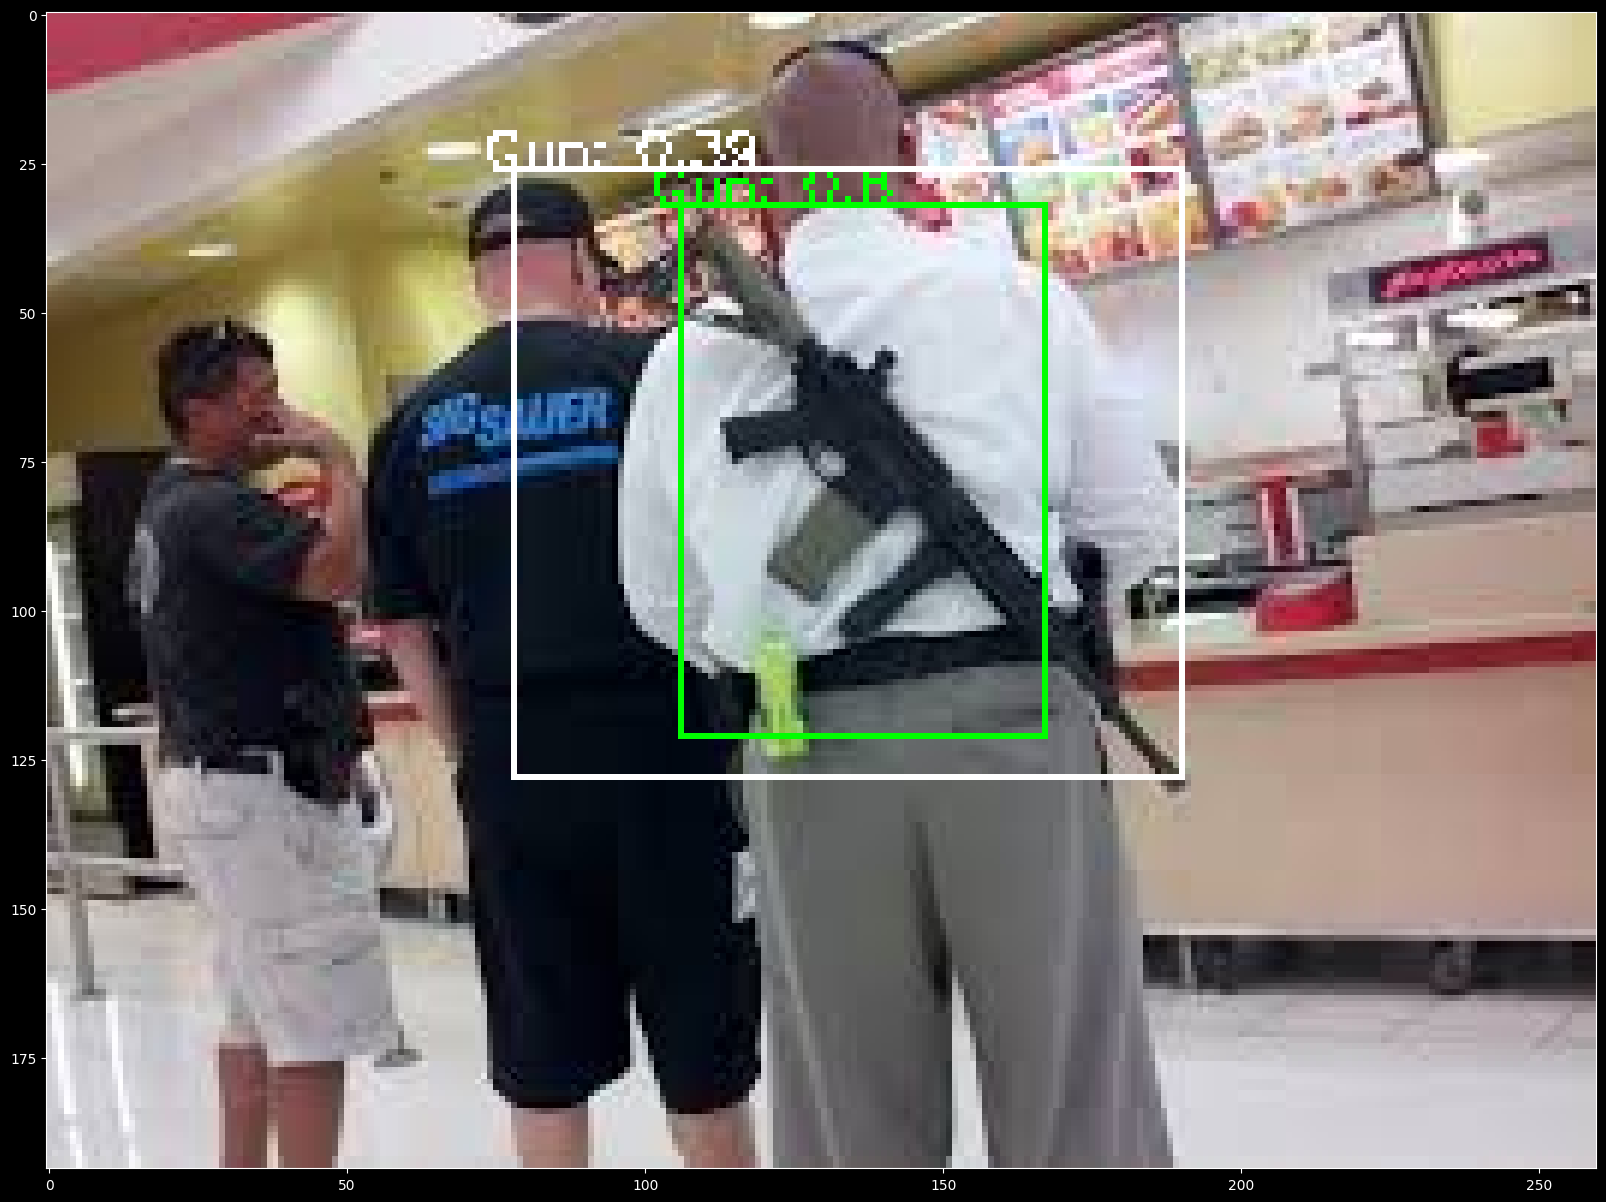

In [30]:
testGun()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


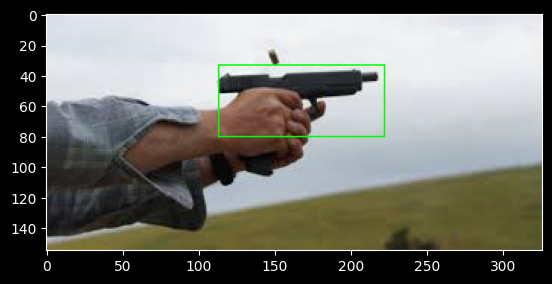

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

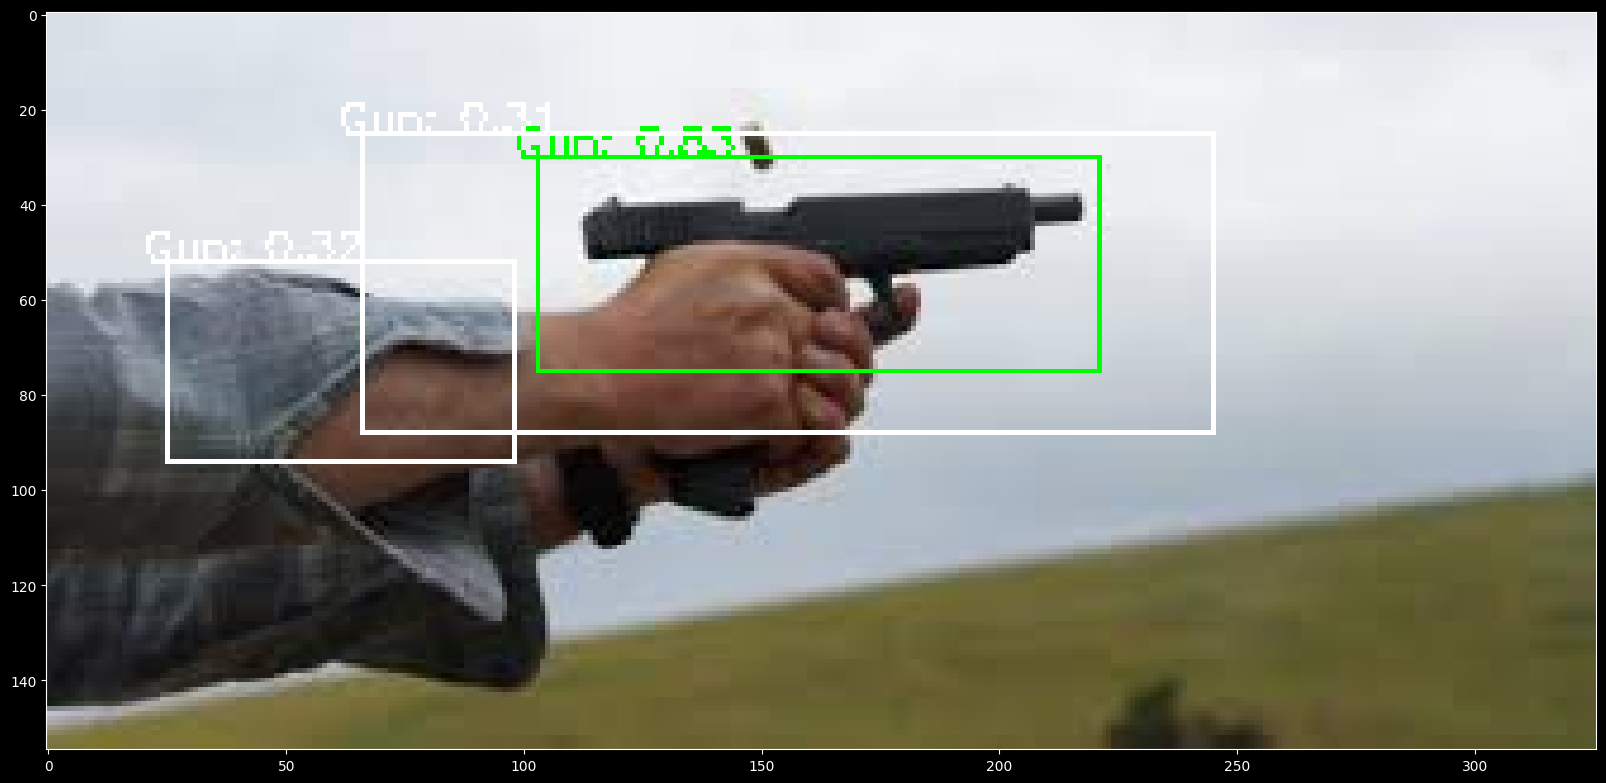

In [31]:
testGun()